In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Set, Dict
from enum import Enum
import time
import random
import math
from copy import deepcopy

print("Libraries imported successfully!")

Libraries imported successfully!


## Define Constants and Antenna Specifications

We define three antenna types with their properties:
- **Small**: Shortest range, cheapest
- **Medium**: Moderate range and cost
- **Large**: Longest range, most expensive

In [3]:
# Constants
USERS_PER_HOUSE = 100

# Antenna Types
class AntennaType(str, Enum):
    SMALL = "Small"
    MEDIUM = "Medium"
    LARGE = "Large"

# Antenna Specifications
class AntennaSpec:
    def __init__(self, type: AntennaType, radius: int, cost: int):
        self.type = type
        self.radius = radius
        self.cost = cost
    
    def __repr__(self):
        return f"{self.type.value}(radius={self.radius}, cost=${self.cost})"

# Define antenna specifications
ANTENNA_SPECS = {
    AntennaType.SMALL: AntennaSpec(AntennaType.SMALL, radius=2, cost=1000),
    AntennaType.MEDIUM: AntennaSpec(AntennaType.MEDIUM, radius=4, cost=1500),
    AntennaType.LARGE: AntennaSpec(AntennaType.LARGE, radius=6, cost=2000),
}

print("Antenna Specifications:")
for spec in ANTENNA_SPECS.values():
    print(f"  {spec}")

Antenna Specifications:
  Small(radius=2, cost=$1000)
  Medium(radius=4, cost=$1500)
  Large(radius=6, cost=$2000)


## Simulated Annealing Concepts

**Key Concepts:**
- **Energy Function**: Evaluates solution quality (lower is better)
- **Temperature**: Controls exploration vs exploitation
- **Cooling Schedule**: Gradually reduces temperature over time
- **Neighbor Generation**: Creates similar solutions through random modifications
- **Metropolis Criterion**: Accepts worse solutions probabilistically

**Energy Function:**
```
energy = uncovered_penalty + cost_penalty
```
where:
- `uncovered_penalty` = uncovered_users × 10.0
- `cost_penalty` = total_cost / 1000

**Acceptance Probability:**
```
if new_energy < current_energy:
    accept = True
else:
    accept with probability = exp(-(new_energy - current_energy) / temperature)
```

## Implement Simulated Annealing Algorithm Class

In [4]:
class SimulatedAnnealingAlgorithm:
    """Simulated Annealing algorithm for antenna placement optimization."""
    
    # Configuration constants
    UNCOVERED_USER_PENALTY = 10.0
    COST_DIVISOR = 1000
    
    OPERATION_WEIGHT_ADD = 30
    OPERATION_WEIGHT_REMOVE = 30
    OPERATION_WEIGHT_MOVE = 25
    OPERATION_WEIGHT_CHANGE_TYPE = 15
    
    INITIAL_LARGE_ANTENNA_BIAS = 0.5
    MAX_INITIAL_ANTENNAS = 5
    
    def __init__(
        self,
        width: int,
        height: int,
        antenna_specs: Dict[AntennaType, AntennaSpec],
        houses: List[Tuple[int, int]],
        initial_temperature: float = 100.0,
        cooling_rate: float = 0.95,
        min_temperature: float = 0.1,
        iterations_per_temp: int = 100,
        random_seed: int = None
    ):
        self.width = width
        self.height = height
        self.antenna_specs = antenna_specs
        self.houses = set(houses)
        self.total_users = len(houses) * USERS_PER_HOUSE
        self.initial_temperature = initial_temperature
        self.cooling_rate = cooling_rate
        self.min_temperature = min_temperature
        self.iterations_per_temp = iterations_per_temp
        
        if random_seed is not None:
            random.seed(random_seed)
        
        print(f"Initialized Simulated Annealing: {width}x{height} grid, {len(houses)} houses")
        print(f"Temperature: {initial_temperature} → {min_temperature}, Cooling: {cooling_rate}")
    
    def get_coverage_area(self, x: int, y: int, radius: int) -> Tuple[Set[Tuple[int, int]], Set[Tuple[int, int]]]:
        """Calculate coverage area for an antenna."""
        covered_cells = set()
        covered_houses = set()
        
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.width and 0 <= ny < self.height:
                    distance = math.sqrt(dx*dx + dy*dy)
                    if distance <= radius:
                        if (nx, ny) in self.houses:
                            covered_houses.add((nx, ny))
                        else:
                            covered_cells.add((nx, ny))
        
        return covered_cells, covered_houses
    
    def calculate_solution_metrics(self, antennas: List[Dict]) -> Tuple[float, int, int, int]:
        """Calculate metrics for a solution."""
        covered_cells = set()
        covered_houses = set()
        total_cost = 0
        
        for antenna in antennas:
            cells, houses = self.get_coverage_area(antenna['x'], antenna['y'], antenna['radius'])
            covered_cells.update(cells)
            covered_houses.update(houses)
            total_cost += antenna['cost']
        
        users_covered = len(covered_houses) * USERS_PER_HOUSE
        
        if self.total_users > 0:
            uncovered_users = self.total_users - users_covered
        else:
            uncovered_users = 0
        
        # Energy function
        uncovered_penalty = uncovered_users * self.UNCOVERED_USER_PENALTY
        cost_penalty = total_cost / self.COST_DIVISOR if total_cost > 0 else 0
        energy = uncovered_penalty + cost_penalty
        
        total_coverage = len(covered_cells) + len(covered_houses)
        
        return energy, total_cost, users_covered, total_coverage
    
    def is_valid_position(self, x: int, y: int) -> bool:
        """Check if position is valid for antenna placement."""
        return (0 <= x < self.width and
                0 <= y < self.height and
                (x, y) not in self.houses)
    
    def antenna_covers_houses(self, x: int, y: int, radius: int) -> bool:
        """Check if antenna covers at least one house."""
        for house in self.houses:
            hx, hy = house
            distance = math.sqrt((x - hx)**2 + (y - hy)**2)
            if distance <= radius:
                return True
        return False
    
    def generate_initial_solution(self) -> List[Dict]:
        """Generate initial solution by placing antennas near houses."""
        antennas = []
        max_initial = min(self.MAX_INITIAL_ANTENNAS, len(self.houses))
        
        house_list = list(self.houses)
        if not house_list:
            return antennas
        
        # Prefer larger antenna types initially
        antenna_types = sorted(self.antenna_specs.keys(), 
                             key=lambda t: self.antenna_specs[t].radius, 
                             reverse=True)
        
        placed_positions = set()
        attempts = 0
        max_attempts = max_initial * 10
        
        while len(antennas) < max_initial and attempts < max_attempts:
            attempts += 1
            
            # Select random house
            house_x, house_y = random.choice(house_list)
            
            # Choose antenna type (bias toward larger)
            if random.random() < self.INITIAL_LARGE_ANTENNA_BIAS:
                antenna_type = antenna_types[0]  # Largest
            else:
                antenna_type = random.choice(antenna_types)
            
            spec = self.antenna_specs[antenna_type]
            
            # Try to place near house
            for _ in range(10):
                offset = random.randint(-spec.radius, spec.radius)
                x = house_x + offset
                y = house_y + random.randint(-spec.radius, spec.radius)
                
                if (x, y) not in placed_positions and self.is_valid_position(x, y):
                    if self.antenna_covers_houses(x, y, spec.radius):
                        antennas.append({
                            'x': x, 'y': y,
                            'type': antenna_type,
                            'radius': spec.radius,
                            'cost': spec.cost
                        })
                        placed_positions.add((x, y))
                        break
        
        print(f"Generated initial solution with {len(antennas)} antennas")
        return antennas
    
    def generate_neighbor(self, current_solution: List[Dict]) -> List[Dict]:
        """Generate neighboring solution through random modification."""
        new_solution = [ant.copy() for ant in current_solution]
        
        if not new_solution:
            return self.generate_initial_solution()
        
        operation = random.choices(
            ["add", "remove", "move", "change_type"],
            weights=[self.OPERATION_WEIGHT_ADD, self.OPERATION_WEIGHT_REMOVE,
                    self.OPERATION_WEIGHT_MOVE, self.OPERATION_WEIGHT_CHANGE_TYPE],
            k=1
        )[0]
        
        occupied_positions = {(ant['x'], ant['y']) for ant in new_solution}
        
        if operation == "add":
            # Add new antenna
            for _ in range(20):
                x = random.randint(0, self.width - 1)
                y = random.randint(0, self.height - 1)
                
                if (x, y) not in occupied_positions and self.is_valid_position(x, y):
                    antenna_type = random.choice(list(self.antenna_specs.keys()))
                    spec = self.antenna_specs[antenna_type]
                    
                    if self.antenna_covers_houses(x, y, spec.radius):
                        new_solution.append({
                            'x': x, 'y': y,
                            'type': antenna_type,
                            'radius': spec.radius,
                            'cost': spec.cost
                        })
                        break
        
        elif operation == "remove" and len(new_solution) > 1:
            new_solution.pop(random.randint(0, len(new_solution) - 1))
        
        elif operation == "move" and new_solution:
            idx = random.randint(0, len(new_solution) - 1)
            antenna = new_solution[idx]
            
            for _ in range(10):
                new_x = antenna['x'] + random.randint(-2, 2)
                new_y = antenna['y'] + random.randint(-2, 2)
                
                if (new_x, new_y) not in occupied_positions and self.is_valid_position(new_x, new_y):
                    if self.antenna_covers_houses(new_x, new_y, antenna['radius']):
                        antenna['x'] = new_x
                        antenna['y'] = new_y
                        break
        
        elif operation == "change_type" and new_solution:
            idx = random.randint(0, len(new_solution) - 1)
            antenna = new_solution[idx]
            new_type = random.choice(list(self.antenna_specs.keys()))
            spec = self.antenna_specs[new_type]
            
            if self.antenna_covers_houses(antenna['x'], antenna['y'], spec.radius):
                antenna['type'] = new_type
                antenna['radius'] = spec.radius
                antenna['cost'] = spec.cost
        
        return new_solution
    
    def acceptance_probability(self, current_energy: float, new_energy: float, temperature: float) -> float:
        """Calculate acceptance probability using Metropolis criterion."""
        if new_energy < current_energy:
            return 1.0
        if temperature <= 0:
            return 0.0
        return math.exp(-(new_energy - current_energy) / temperature)
    
    def remove_useless_antennas(self, antennas: List[Dict]) -> List[Dict]:
        """Remove antennas that don't cover any houses."""
        useful_antennas = []
        removed_count = 0
        
        for antenna in antennas:
            if self.antenna_covers_houses(antenna['x'], antenna['y'], antenna['radius']):
                useful_antennas.append(antenna)
            else:
                removed_count += 1
        
        if removed_count > 0:
            print(f"Removed {removed_count} useless antenna(s)")
        
        return useful_antennas
    
    def optimize(self) -> Dict:
        """Run simulated annealing optimization."""
        print("\nStarting simulated annealing optimization...")
        
        start_time = time.time()
        
        # Generate initial solution
        current_solution = self.generate_initial_solution()
        current_energy, current_cost, current_users, current_cells = self.calculate_solution_metrics(current_solution)
        
        # Track best solution
        best_solution = [ant.copy() for ant in current_solution]
        best_energy = current_energy
        best_metrics = (current_cost, current_users, current_cells)
        
        print(f"Initial: {len(current_solution)} antennas, energy={current_energy:.4f}, users={current_users}, cost=${current_cost}")
        
        temperature = self.initial_temperature
        iteration = 0
        accepted_moves = 0
        total_moves = 0
        
        # Temperature schedule
        while temperature > self.min_temperature:
            for _ in range(self.iterations_per_temp):
                iteration += 1
                total_moves += 1
                
                # Generate neighbor
                neighbor = self.generate_neighbor(current_solution)
                neighbor_energy, neighbor_cost, neighbor_users, neighbor_cells = self.calculate_solution_metrics(neighbor)
                
                # Acceptance criterion
                accept_prob = self.acceptance_probability(current_energy, neighbor_energy, temperature)
                
                if random.random() < accept_prob:
                    current_solution = neighbor
                    current_energy = neighbor_energy
                    current_cost = neighbor_cost
                    current_users = neighbor_users
                    current_cells = neighbor_cells
                    accepted_moves += 1
                    
                    # Update best solution
                    if neighbor_energy < best_energy:
                        best_solution = [ant.copy() for ant in neighbor]
                        best_energy = neighbor_energy
                        best_metrics = (neighbor_cost, neighbor_users, neighbor_cells)
            
            # Cool down
            temperature *= self.cooling_rate
            
            # Print progress every 10 temperature steps
            if iteration % (self.iterations_per_temp * 10) == 0:
                best_cost, best_users, best_cells = best_metrics
                acceptance_rate = accepted_moves / total_moves if total_moves > 0 else 0
                print(f"  Iteration {iteration}: T={temperature:.4f}, Best Energy={best_energy:.4f}, "
                      f"Users={best_users}, Cost=${best_cost}, Accept={acceptance_rate:.2%}")
        
        # Clean up
        best_solution = self.remove_useless_antennas(best_solution)
        
        # Recalculate final metrics
        if best_solution:
            _, best_cost, best_users, best_cells = self.calculate_solution_metrics(best_solution)
        else:
            best_cost, best_users, best_cells = 0, 0, 0
        
        total_cells = self.width * self.height
        coverage_percentage = (best_cells / total_cells * 100) if total_cells > 0 else 0
        user_coverage_percentage = (best_users / self.total_users * 100) if self.total_users > 0 else 0
        
        execution_time_ms = (time.time() - start_time) * 1000
        
        print(f"\n✓ Simulated annealing complete!")
        print(f"  Antennas placed: {len(best_solution)}")
        print(f"  Total cost: ${best_cost:,}")
        print(f"  Houses covered: {len(self.houses)}")
        print(f"  Users covered: {best_users:,}/{self.total_users:,} ({user_coverage_percentage:.1f}%)")
        print(f"  Area coverage: {best_cells}/{total_cells} cells ({coverage_percentage:.1f}%)")
        print(f"  Execution time: {execution_time_ms:.2f} ms")
        
        return {
            "antennas": best_solution,
            "houses_covered": len([h for h in self.houses if any(
                math.sqrt((ant['x']-h[0])**2 + (ant['y']-h[1])**2) <= ant['radius'] 
                for ant in best_solution
            )]),
            "total_houses": len(self.houses),
            "users_covered": best_users,
            "total_users": self.total_users,
            "coverage_percentage": user_coverage_percentage,
            "total_cost": best_cost,
            "execution_time_ms": execution_time_ms
        }

print("SimulatedAnnealingAlgorithm class defined successfully!")

SimulatedAnnealingAlgorithm class defined successfully!


## Create Sample Grid

In [5]:
# Create a sample grid
np.random.seed(42)
GRID_WIDTH = 20
GRID_HEIGHT = 15

# Generate random house positions (15% of grid cells)
num_houses = int(GRID_WIDTH * GRID_HEIGHT * 0.15)
houses = []
while len(houses) < num_houses:
    x = np.random.randint(0, GRID_WIDTH)
    y = np.random.randint(0, GRID_HEIGHT)
    if (x, y) not in houses:
        houses.append((x, y))

print(f"Grid size: {GRID_WIDTH}x{GRID_HEIGHT}")
print(f"Number of houses: {len(houses)}")
print(f"Total users: {len(houses) * USERS_PER_HOUSE}")

Grid size: 20x15
Number of houses: 45
Total users: 4500


## Run Simulated Annealing Algorithm

In [6]:
# Initialize and run the simulated annealing algorithm
sa_algo = SimulatedAnnealingAlgorithm(
    width=GRID_WIDTH,
    height=GRID_HEIGHT,
    antenna_specs=ANTENNA_SPECS,
    houses=houses,
    initial_temperature=100.0,
    cooling_rate=0.95,
    min_temperature=0.1,
    iterations_per_temp=100,
    random_seed=42  # For reproducibility
)

result = sa_algo.optimize()

Initialized Simulated Annealing: 20x15 grid, 45 houses
Temperature: 100.0 → 0.1, Cooling: 0.95

Starting simulated annealing optimization...
Generated initial solution with 5 antennas
Initial: 5 antennas, energy=5009.0000, users=4000, cost=$9000
  Iteration 1000: T=59.8737, Best Energy=12.0000, Users=4500, Cost=$12000, Accept=93.50%
  Iteration 1000: T=59.8737, Best Energy=12.0000, Users=4500, Cost=$12000, Accept=93.50%
  Iteration 2000: T=35.8486, Best Energy=12.0000, Users=4500, Cost=$12000, Accept=93.80%
  Iteration 2000: T=35.8486, Best Energy=12.0000, Users=4500, Cost=$12000, Accept=93.80%
  Iteration 3000: T=21.4639, Best Energy=12.0000, Users=4500, Cost=$12000, Accept=95.17%
  Iteration 3000: T=21.4639, Best Energy=12.0000, Users=4500, Cost=$12000, Accept=95.17%
  Iteration 4000: T=12.8512, Best Energy=12.0000, Users=4500, Cost=$12000, Accept=94.95%
  Iteration 4000: T=12.8512, Best Energy=12.0000, Users=4500, Cost=$12000, Accept=94.95%
  Iteration 5000: T=7.6945, Best Energy=11

## Visualize Results

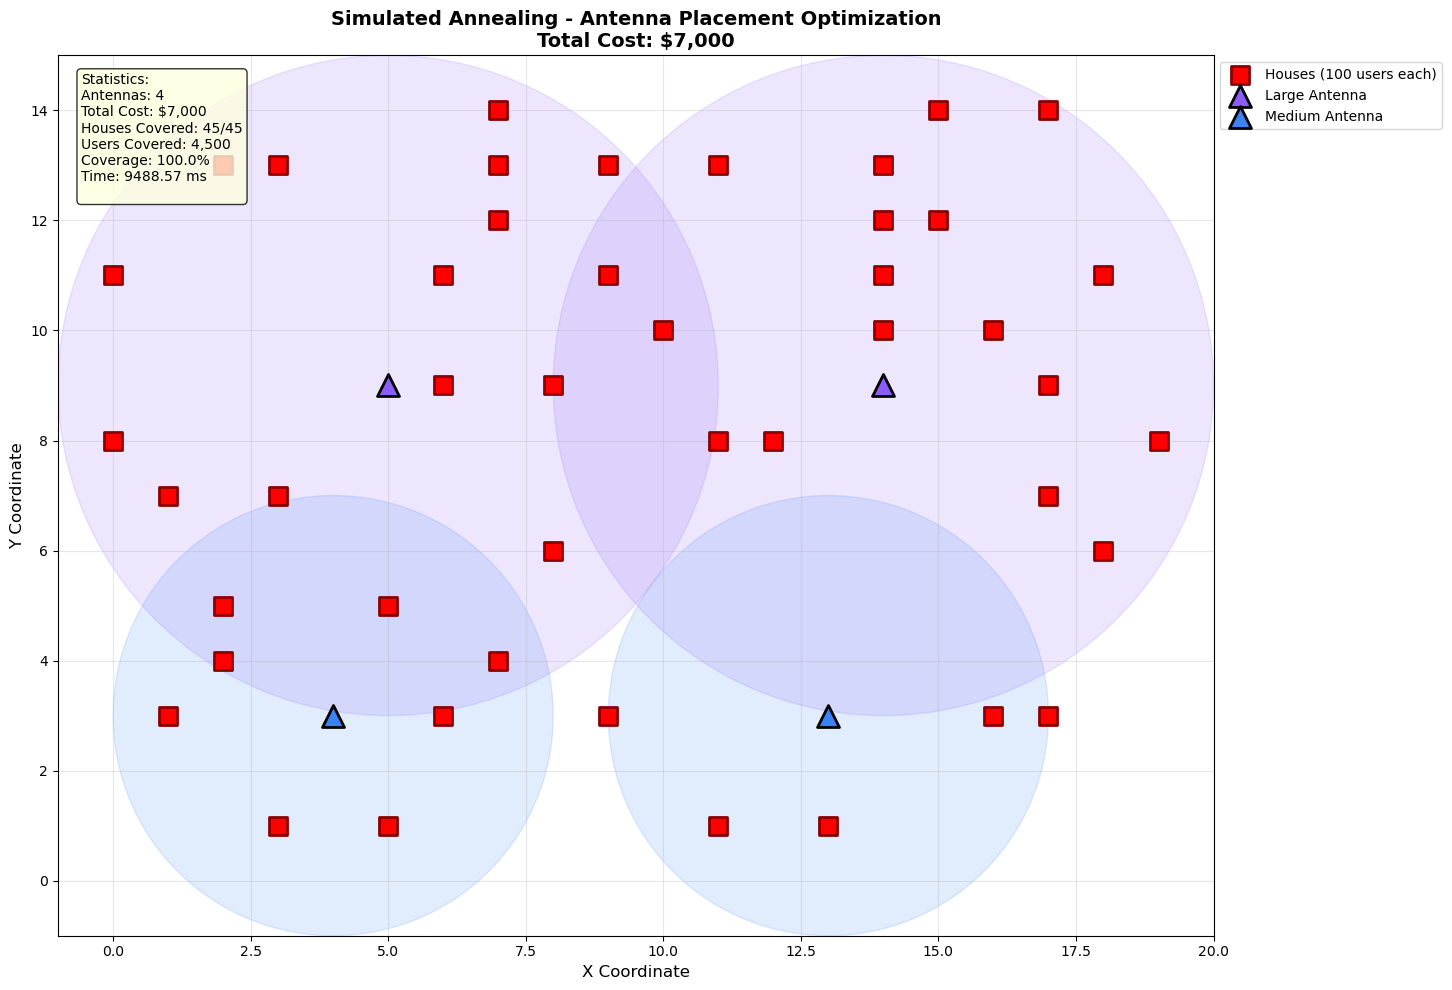


Antenna Breakdown by Type:
  Large: 2 antenna(s) - $4,000
  Medium: 2 antenna(s) - $3,000


In [7]:
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Define colors for each antenna type
antenna_colors = {
    AntennaType.SMALL: '#10B981',   # Green
    AntennaType.MEDIUM: '#3B82F6',  # Blue
    AntennaType.LARGE: '#8B5CF6',   # Purple
}

# Plot coverage circles first (so they're in the background)
for antenna in result['antennas']:
    color = antenna_colors[antenna['type']]
    circle = plt.Circle((antenna['x'], antenna['y']), antenna['radius'], 
                        color=color, alpha=0.15, zorder=1)
    ax.add_patch(circle)

# Plot houses
if houses:
    houses_x, houses_y = zip(*houses)
    ax.scatter(houses_x, houses_y, c='red', s=150, marker='s', 
              label='Houses (100 users each)', zorder=3, edgecolors='darkred', linewidth=2)

# Plot antennas
antenna_types = {}
for antenna in result['antennas']:
    ant_type = antenna['type']
    if ant_type not in antenna_types:
        antenna_types[ant_type] = {'x': [], 'y': []}
    antenna_types[ant_type]['x'].append(antenna['x'])
    antenna_types[ant_type]['y'].append(antenna['y'])

for ant_type, coords in antenna_types.items():
    color = antenna_colors[ant_type]
    ax.scatter(coords['x'], coords['y'], c=color, s=250, marker='^', 
              label=f'{ant_type.value} Antenna', zorder=4, 
              edgecolors='black', linewidth=2)

# Set grid
ax.set_xlim(-1, GRID_WIDTH)
ax.set_ylim(-1, GRID_HEIGHT)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title(f'Simulated Annealing - Antenna Placement Optimization\nTotal Cost: ${result["total_cost"]:,}', 
            fontsize=14, fontweight='bold')

# Add legend
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Add statistics text box
stats_text = f"""Statistics:
Antennas: {len(result['antennas'])}
Total Cost: ${result['total_cost']:,}
Houses Covered: {result['houses_covered']}/{result['total_houses']}
Users Covered: {result['users_covered']:,}
Coverage: {result['coverage_percentage']:.1f}%
Time: {result['execution_time_ms']:.2f} ms
"""
props = dict(boxstyle='round', facecolor='lightyellow', alpha=0.8)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Print antenna breakdown
print("\nAntenna Breakdown by Type:")
antenna_counts = {}
antenna_costs = {}
for antenna in result['antennas']:
    ant_type = antenna['type']
    antenna_counts[ant_type] = antenna_counts.get(ant_type, 0) + 1
    antenna_costs[ant_type] = antenna_costs.get(ant_type, 0) + antenna['cost']

for ant_type in sorted(antenna_counts.keys(), key=lambda x: x.value):
    count = antenna_counts[ant_type]
    cost = antenna_costs[ant_type]
    print(f"  {ant_type.value}: {count} antenna(s) - ${cost:,}")

## Compare Temperature Settings

Let's experiment with different temperature parameters to see their effect on solution quality.

In [8]:
# Test different temperature configurations
temperature_configs = [
    {"name": "Fast (High Cooling)", "init_temp": 50.0, "cooling": 0.90},
    {"name": "Balanced (Default)", "init_temp": 100.0, "cooling": 0.95},
    {"name": "Slow (Low Cooling)", "init_temp": 150.0, "cooling": 0.98},
]

temp_results = []

for config in temperature_configs:
    print("\n" + "="*70)
    print(f"TEST: {config['name']}")
    print(f"  Initial Temperature: {config['init_temp']}, Cooling Rate: {config['cooling']}")
    print("="*70)
    
    algo = SimulatedAnnealingAlgorithm(
        width=GRID_WIDTH,
        height=GRID_HEIGHT,
        antenna_specs=ANTENNA_SPECS,
        houses=houses,
        initial_temperature=config['init_temp'],
        cooling_rate=config['cooling'],
        min_temperature=0.1,
        iterations_per_temp=50,  # Reduced for faster comparison
        random_seed=42
    )
    
    result = algo.optimize()
    temp_results.append({
        "name": config['name'],
        "antennas": len(result['antennas']),
        "cost": result['total_cost'],
        "coverage": result['coverage_percentage'],
        "time": result['execution_time_ms']
    })

# Display comparison
print("\n" + "="*70)
print("TEMPERATURE CONFIGURATION COMPARISON")
print("="*70)
print(f"{'Configuration':<25} {'Antennas':<12} {'Cost':<12} {'Coverage':<12} {'Time (ms)':<10}")
print("-" * 70)
for r in temp_results:
    print(f"{r['name']:<25} {r['antennas']:<12} ${r['cost']:<11,} {r['coverage']:<11.1f}% {r['time']:<10.2f}")

print("\nKey Insights:")
print("  - Fast cooling: Quicker execution but may miss better solutions")
print("  - Slow cooling: Better exploration but longer runtime")
print("  - Balanced approach typically provides good quality/speed trade-off")


TEST: Fast (High Cooling)
  Initial Temperature: 50.0, Cooling Rate: 0.9
Initialized Simulated Annealing: 20x15 grid, 45 houses
Temperature: 50.0 → 0.1, Cooling: 0.9

Starting simulated annealing optimization...
Generated initial solution with 5 antennas
Initial: 5 antennas, energy=5009.0000, users=4000, cost=$9000
  Iteration 500: T=17.4339, Best Energy=12.0000, Users=4500, Cost=$12000, Accept=87.80%
  Iteration 500: T=17.4339, Best Energy=12.0000, Users=4500, Cost=$12000, Accept=87.80%
  Iteration 1000: T=6.0788, Best Energy=11.5000, Users=4500, Cost=$11500, Accept=85.30%
  Iteration 1000: T=6.0788, Best Energy=11.5000, Users=4500, Cost=$11500, Accept=85.30%
  Iteration 1500: T=2.1196, Best Energy=11.5000, Users=4500, Cost=$11500, Accept=81.87%
  Iteration 1500: T=2.1196, Best Energy=11.5000, Users=4500, Cost=$11500, Accept=81.87%
  Iteration 2000: T=0.7390, Best Energy=8.0000, Users=4500, Cost=$8000, Accept=72.70%
  Iteration 2500: T=0.2577, Best Energy=7.5000, Users=4500, Cost=$75

## Algorithm Summary

**Key Features:**
- **Probabilistic optimization**: Inspired by physical annealing process
- **Temperature-controlled exploration**: High temp = explore, low temp = exploit
- **Energy minimization**: Balances coverage and cost objectives
- **Metropolis acceptance**: Can accept worse solutions to escape local optima
- **Complexity**: O(I × T × N × W × H) where:
  - I = total iterations
  - T = antenna types
  - N = number of houses
  - W × H = grid size

**Advantages:**
- ✓ Escapes local optima
- ✓ Finds high-quality solutions
- ✓ Flexible energy function
- ✓ Simpler than genetic algorithms

**Limitations:**
- ✗ Slower than greedy (seconds vs milliseconds)
- ✗ Non-deterministic results
- ✗ Requires parameter tuning
- ✗ No global optimum guarantee

**When to use:**
- When greedy solutions are suboptimal
- For cost-critical applications
- When execution time is acceptable
- For complex optimization landscapes

**Comparison with other algorithms:**
- **vs Greedy**: 10-25% cost reduction, 100x slower
- **vs Genetic**: Similar quality, simpler implementation
- **vs Brute Force**: Near-optimal in practical time